<a href="https://colab.research.google.com/github/mbmarcin/ml_/blob/main/wine_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
from sklearn.feature_selection import RFE
from scipy.stats import randint
from sklearn import tree
import graphviz

In [ ]:
wines = pd.read_csv('winequality-all.csv')
wines.columns

Index(['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar',
       'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'response', 'color'],
      dtype='object')

In [ ]:
summary = pd.DataFrame(wines.dtypes, columns=['Feature type'])
summary['Is any null?'] = wines.isnull().any()
summary['Sum of nulls'] = wines.isnull().sum()
summary['Percent of nulls'] = round((wines.apply(pd.isnull).mean()*100),2)
summary

,Feature type,Is any null?,Sum of nulls,Percent of nulls
fixed.acidity,float64,False,0,0.0
volatile.acidity,float64,False,0,0.0
citric.acid,float64,False,0,0.0
residual.sugar,float64,False,0,0.0
chlorides,float64,False,0,0.0
free.sulfur.dioxide,float64,False,0,0.0
total.sulfur.dioxide,float64,False,0,0.0
density,float64,False,0,0.0
pH,float64,False,0,0.0
sulphates,float64,False,0,0.0


In [ ]:
wines.agg(['mean', 'median'])

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,response
mean,7.215179,0.34413,0.318494,5.048477,0.05669,30.036654,114.109023,0.994535,3.224664,0.533357,10.549241,3.795677
median,7.000000,0.30000,0.310000,2.700000,0.04700,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,4.000000


In [ ]:
wines.color.value_counts(normalize = True)

white    0.744549
red      0.255451
Name: color, dtype: float64

In [ ]:
for feature in wines.columns.drop('color'):
    alpha = 0.05
    p_value = scipy.stats.normaltest(wines[feature])[1]
    
    if(p_value < alpha):
        print('For feature \'' + feature +'\' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.')
    else:
        print('For feature \'' + feature +'\' null hypothesis can not be rejected. Sample COMES from normal distribution.')

For feature 'fixed.acidity' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'volatile.acidity' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'citric.acid' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'residual.sugar' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'chlorides' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'free.sulfur.dioxide' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'total.sulfur.dioxide' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'density' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'pH' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'sulphates' null hypot

In [ ]:
wines.columns

Index(['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar',
       'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'response', 'color'],
      dtype='object')

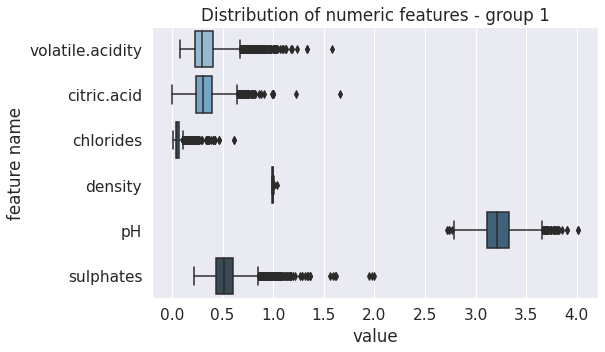

In [ ]:
melted_wines_df_1 = pd.melt(wines, value_vars=wines.drop(['color', 'total.sulfur.dioxide', 'free.sulfur.dioxide', 'residual.sugar', 'fixed.acidity', 'alcohol', 'response'], axis = 1).columns, var_name=['feature_name'], value_name = 'value')
melted_wines_df_2 = pd.melt(wines, value_vars=wines[['fixed.acidity', 'alcohol', 'response']].columns, var_name=['feature_name'], value_name = 'value')
melted_wines_df_3 = pd.melt(wines, value_vars=wines[['total.sulfur.dioxide', 'free.sulfur.dioxide', 'residual.sugar', 'fixed.acidity', 'alcohol', 'response']].columns, var_name=['feature_name'], value_name = 'value')

plt.figure(figsize=(8,5))
sns.set(font_scale=1.4)
sns.boxplot(data = melted_wines_df_1, y = 'feature_name', x = 'value', palette = 'Blues_d').set(title = 'Distribution of numeric features - group 1', ylabel = 'feature name')
plt.show()


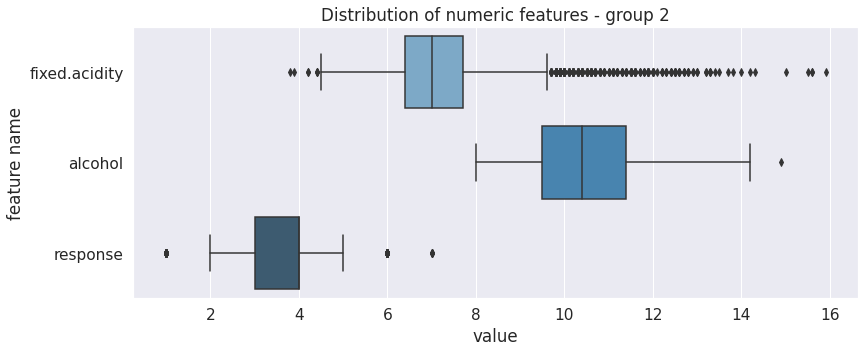

In [ ]:
plt.figure(figsize=(13,5))
sns.set(font_scale=1.4)
sns.boxplot(data = melted_wines_df_2, y = 'feature_name', x = 'value', palette = 'Blues_d').set(title = 'Distribution of numeric features - group 2', ylabel = 'feature name')
plt.show()

In [ ]:

# Outliers detection.

# There are two methods of detecting outliers:

#     3 sigma rule,
#     1.5 interquartile range.

# First of them has strong assumption: normallly distributed features. I can not use it, so I decide to use second.

q1 = wines.drop(['color', 'response'], axis = 1).quantile(0.25)
q3 = wines.drop(['color', 'response'], axis = 1).quantile(0.75)
iqr = q3 - q1
iqr

fixed.acidity            1.30000
volatile.acidity         0.18000
citric.acid              0.16000
residual.sugar           5.70000
chlorides                0.02800
free.sulfur.dioxide     25.00000
total.sulfur.dioxide    79.25000
density                  0.00457
pH                       0.22000
sulphates                0.17000
alcohol                  1.90000
dtype: float64

In [ ]:
low_boundary = (q1 - 1.5 * iqr)
upp_boundary = (q3 + 1.5 * iqr)
num_of_outliers_L = (wines.drop(['color', 'response'], axis = 1)[iqr.index] < low_boundary).sum()
num_of_outliers_U = (wines.drop(['color', 'response'], axis = 1)[iqr.index] > upp_boundary).sum()
outliers = pd.DataFrame({'lower_boundary':low_boundary, 'upper_boundary':upp_boundary,'num_of_outliers_L':num_of_outliers_L, 'num_of_outliers_U':num_of_outliers_U})
outliers


,lower_boundary,upper_boundary,num_of_outliers_L,num_of_outliers_U
fixed.acidity,4.450000e+00,9.650000,7,297
volatile.acidity,-4.000000e-02,0.680000,0,279
citric.acid,-5.551115e-17,0.640000,0,143
residual.sugar,-6.750000e+00,16.050000,0,141
chlorides,-4.000000e-03,0.108000,0,237
free.sulfur.dioxide,-2.150000e+01,78.500000,0,44
total.sulfur.dioxide,-4.487500e+01,272.125000,0,10
density,9.853450e-01,1.003625,0,3
pH,2.780000e+00,3.660000,4,45
sulphates,1.750000e-01,0.855000,0,163


In [ ]:
## remove outliers

w = wines.copy()


In [ ]:
for row in outliers.iterrows():
    w = w[(w[row[0]] >= row[1]['lower_boundary']) & (w[row[0]] <= row[1]['upper_boundary'])]
print(w.shape)
print(wines.shape)

(4226, 13)
(5320, 13)


In [ ]:
 ## Analysis of correlation between target variable and other features.

correlation_matrix = pd.DataFrame(np.abs(scipy.stats.spearmanr(wines)[0]), columns = wines.columns, index = wines.columns)
correlation_matrix.drop('color', axis = 0, inplace = True)
correlation_matrix.reset_index(inplace=True)

correlation_matrix


,index,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,response,color
0,fixed.acidity,1.000000,0.206593,0.278841,0.025441,0.359324,0.266580,0.247357,0.450184,0.262258,0.229855,0.113936,0.104029,0.429236
1,volatile.acidity,0.206593,1.000000,0.303870,0.021323,0.432466,0.370346,0.341317,0.310026,0.178650,0.263985,0.061742,0.251450,0.601336
2,citric.acid,0.278841,0.303870,1.000000,0.073252,0.062915,0.117661,0.156361,0.062847,0.305331,0.031671,0.024059,0.116477,0.157784
3,residual.sugar,0.025441,0.021323,0.073252,1.000000,0.032791,0.363153,0.428820,0.493452,0.194395,0.117949,0.266348,0.028170,0.219714
4,chlorides,0.359324,0.432466,0.062915,0.032791,1.000000,0.261093,0.278533,0.608994,0.160172,0.376322,0.417115,0.303872,0.668152
5,free.sulfur.dioxide,0.266580,0.370346,0.117661,0.363153,0.261093,1.000000,0.741566,0.024871,0.161797,0.236049,0.166343,0.089978,0.516525
6,total.sulfur.dioxide,0.247357,0.341317,0.156361,0.428820,0.278533,0.741566,1.000000,0.021789,0.228878,0.264330,0.280905,0.058229,0.678997
7,density,0.450184,0.310026,0.062847,0.493452,0.608994,0.024871,0.021789,1.000000,0.039593,0.302401,0.683486,0.349012,0.453556
8,pH,0.262258,0.178650,0.305331,0.194395,0.160172,0.161797,0.228878,0.039593,1.000000,0.235296,0.110308,0.052798,0.318942
9,sulphates,0.229855,0.263985,0.031671,0.117949,0.376322,0.236049,0.264330,0.302401,0.235296,1.000000,0.017053,0.035769,0.499328


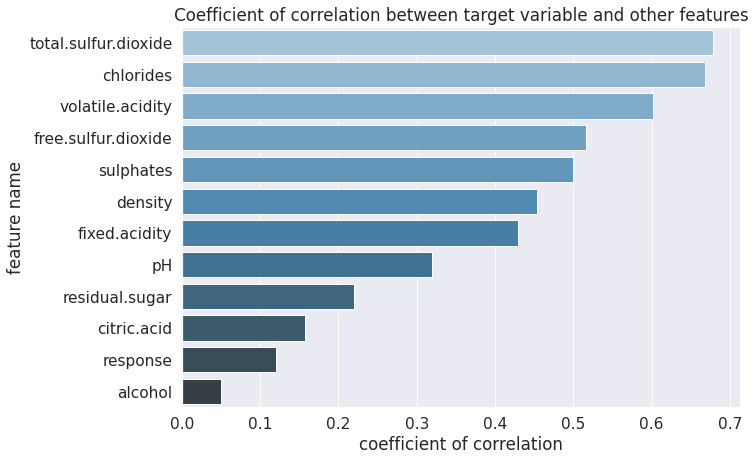

In [ ]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.barplot(data = correlation_matrix.sort_values('color', ascending=False), x = 'color', y = 'index', palette = 'Blues_d').set(title = 'Coefficient of correlation between target variable and other features', xlabel = 'coefficient of correlation', ylabel = 'feature name')
plt.show()

In [ ]:
correlation_matrix = pd.DataFrame(np.abs(scipy.stats.spearmanr(wines.drop('color', axis = 1))[0]), columns = wines.drop('color', axis = 1).columns, index = wines.drop('color', axis = 1).columns)
correlation_matrix

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,response
fixed.acidity,1.000000,0.206593,0.278841,0.025441,0.359324,0.266580,0.247357,0.450184,0.262258,0.229855,0.113936,0.104029
volatile.acidity,0.206593,1.000000,0.303870,0.021323,0.432466,0.370346,0.341317,0.310026,0.178650,0.263985,0.061742,0.251450
citric.acid,0.278841,0.303870,1.000000,0.073252,0.062915,0.117661,0.156361,0.062847,0.305331,0.031671,0.024059,0.116477
residual.sugar,0.025441,0.021323,0.073252,1.000000,0.032791,0.363153,0.428820,0.493452,0.194395,0.117949,0.266348,0.028170
chlorides,0.359324,0.432466,0.062915,0.032791,1.000000,0.261093,0.278533,0.608994,0.160172,0.376322,0.417115,0.303872
free.sulfur.dioxide,0.266580,0.370346,0.117661,0.363153,0.261093,1.000000,0.741566,0.024871,0.161797,0.236049,0.166343,0.089978
total.sulfur.dioxide,0.247357,0.341317,0.156361,0.428820,0.278533,0.741566,1.000000,0.021789,0.228878,0.264330,0.280905,0.058229
density,0.450184,0.310026,0.062847,0.493452,0.608994,0.024871,0.021789,1.000000,0.039593,0.302401,0.683486,0.349012
pH,0.262258,0.178650,0.305331,0.194395,0.160172,0.161797,0.228878,0.039593,1.000000,0.235296,0.110308,0.052798
sulphates,0.229855,0.263985,0.031671,0.117949,0.376322,0.236049,0.264330,0.302401,0.235296,1.000000,0.017053,0.035769


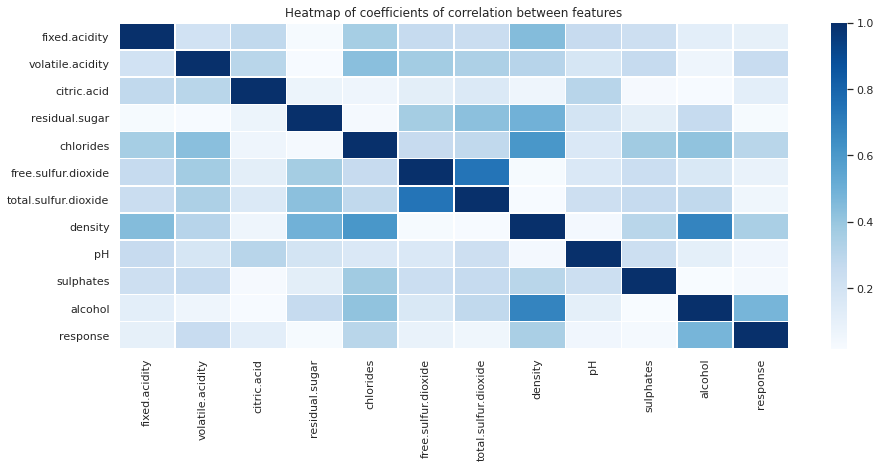

In [ ]:
plt.figure(figsize=(15,6))
sns.set(font_scale=1)
sns.heatmap(correlation_matrix.abs(), cmap="Blues", linewidths=.5).set(title='Heatmap of coefficients of correlation between features')
plt.show()

In [ ]:
# Pair number 1.
ct_1 = pd.crosstab(wines['free.sulfur.dioxide'] > wines['free.sulfur.dioxide'].mean(), wines['total.sulfur.dioxide'] > wines['total.sulfur.dioxide'].mean())
ct_1.index = ["'free.sulfur.dioxide' below mean", "free.sulfur.dioxide' above mean"]
ct_1.columns = ["'total.sulfur.dioxide' below mean", "'total.sulfur.dioxide' above mean"]
ct_1

,'total.sulfur.dioxide' below mean,'total.sulfur.dioxide' above mean
'free.sulfur.dioxide' below mean,2151,809
free.sulfur.dioxide' above mean,445,1915


In [ ]:
# Pair number 2.
ct_2 = pd.crosstab(wines['density'] > wines['density'].mean(), wines['residual.sugar'] > wines['residual.sugar'].mean())
ct_2.index = ["'density' below mean", "density' above mean"]
ct_2.columns = ["'residual.sugar' below mean", "'residual.sugar' above mean"]
ct_2

,'residual.sugar' below mean,'residual.sugar' above mean
'density' below mean,2074,521
density' above mean,1312,1413


In [ ]:
# Pair number 3.
ct_3 = pd.crosstab(wines['density'] > wines['density'].mean(), wines['chlorides'] > wines['chlorides'].mean())
ct_3.index = ["'density' below mean", "density' above mean"]
ct_3.columns = ["'chlorides' below mean", "'chlorides' above mean"]
ct_3

,'chlorides' below mean,'chlorides' above mean
'density' below mean,2321,274
density' above mean,1274,1451


In [ ]:
# Pair number 4. 
ct_4 = pd.crosstab(wines['density'] > wines['density'].mean(), wines['alcohol'] > wines['alcohol'].mean())
ct_4.index = ["'density' below mean", "density' above mean"]
ct_4.columns = ["'alcohol' below mean", "'alcohol' above mean"]
ct_4

,'alcohol' below mean,'alcohol' above mean
'density' below mean,793,1802
density' above mean,2175,550


In [ ]:
# PCA

pca_model_2d = PCA(n_components = 2)
pca_dataset_2d = pd.DataFrame(pca_model_2d.fit_transform(wines.drop('color', axis = 1)), columns = ['component_1', 'component_2'])
pca_dataset_2d['color'] = wines.color.replace([0, 1], ['white', 'red']).values

pca_model_2d

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


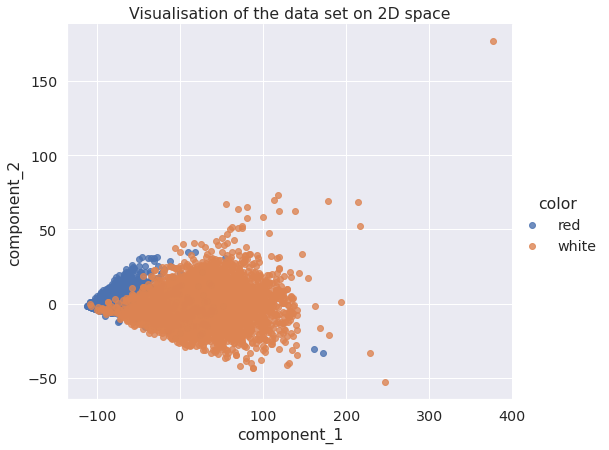

In [ ]:
sns.set(font_scale=1.3)
sns.lmplot(data = pca_dataset_2d, x = 'component_1', y = 'component_2', hue = 'color', fit_reg=False, size=6, aspect=1.2).set(title = 'Visualisation of the data set on 2D space')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


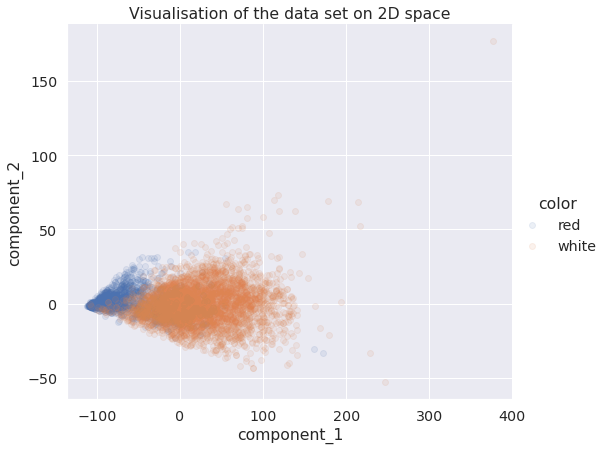

In [ ]:
sns.set(font_scale=1.3)
sns.lmplot(data = pca_dataset_2d, x = 'component_1', y = 'component_2', hue = 'color', fit_reg=False, scatter_kws={'alpha':0.1}, size=6, aspect=1.2).set(title = 'Visualisation of the data set on 2D space')
plt.show()